<a href="https://colab.research.google.com/github/lily-the-real-lilly/first/blob/main/CovidResearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How did a country's population density affect their Covid infection rate? Can we use population density to predict infection rate?

Null Hypothesis: There is no statistically significant correlation between population density and Covid infection rates.

Alternative Hypothesis: There is a statistically significant correlation between population density and Covid infection rates.

# Loading In

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score
!pip install scikit-learn
from sklearn import datasets, model_selection
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from scipy.stats import ttest_ind, ttest_rel

In [2]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
covid_df = pd.read_csv(url)



---



# Convert to to real dates and group by years

In [3]:
#get all dat columns in separate df
date_df = covid_df.iloc[:,4:]
firstfour = covid_df.iloc[:, 0:4]

In [4]:
#convert dates to proper date time format
date_df.columns = pd.to_datetime(date_df.columns)

In [5]:
#group columns by year and aggregate
date_df = date_df.groupby(date_df.columns.year, axis=1).sum()

In [6]:
#make a copy of date_df and add back the first 4 columns of the original df
df = date_df.copy()
regrouped = pd.concat([firstfour, date_df], axis =1)

# Dropping Missing and Irrelevant data

In [7]:
droppedstate = regrouped.drop("Province/State", axis = 1)

In [8]:
droppedstate[droppedstate['Country/Region'] == "Australia"] #Checking to make sure there are duplicates #this is the before

,Country/Region,Lat,Long,2020,2021,2022,2023
9,Australia,-35.4735,149.0124,31115,236803,52065199,15669403
10,Australia,-33.8688,151.2093,1062399,11035814,959337978,263661840
11,Australia,-12.4634,130.8456,10119,67376,26219000,7098463
12,Australia,-27.4698,153.0251,311736,686462,435655307,121185659
13,Australia,-34.9285,138.6007,132836,336089,193297548,59458095
14,Australia,-42.8821,147.3272,61454,88466,62500054,19346892
15,Australia,-37.8136,144.9631,3296025,15608951,714097705,194693571
16,Australia,-31.9505,115.8605,185540,373662,263892268,87161052


In [9]:
contgrouped = droppedstate.groupby('Country/Region').sum().reset_index()
contgrouped[contgrouped['Country/Region'] == "Australia"]

,Country/Region,Lat,Long,2020,2021,2022,2023
9,Australia,-256.8502,1130.8439,5091224,28433623,2707065059,768274975


In [10]:
contgrouped.info() #no nulls yay

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country/Region  201 non-null    object 
 1   Lat             201 non-null    float64
 2   Long            201 non-null    float64
 3   2020            201 non-null    int64  
 4   2021            201 non-null    int64  
 5   2022            201 non-null    int64  
 6   2023            201 non-null    int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 11.1+ KB


In [11]:
# drop 'Antarctica', 'Diamond Princess', 'MS Zaandam' , 'Summer Olympics 2020',  'Winter Olympics 2022'
# ROW 5, 49, 107, 170, 197
df = contgrouped.drop([5, 49, 107, 170, 197])
df[df['Country/Region'] == 'Winter Olympics 2022'] #does work because omlypics does not exist anymore

,Country/Region,Lat,Long,2020,2021,2022,2023


# Region Mapping

In [14]:
region_mapping = {
    'Algeria': 'North Africa',
    'Egypt': 'North Africa',
    'Libya': 'North Africa',
    'Morocco': 'North Africa',
    'Sudan': 'North Africa',
    'Tunisia': 'North Africa',
    'Benin': 'West Africa',
    'Burkina Faso': 'West Africa',
    'Cabo Verde': 'West Africa',
    "Cote d'Ivorie": 'West Africa',
    'Gambia': 'West Africa',
    'Ghana': 'West Africa',
    'Guinea': 'West Africa',
    'Guinea-Bissau': 'West Africa',
    'Liberia': 'West Africa',
    'Mali': 'West Africa',
    'Mauritania': 'West Africa',
    'Niger' : 'West Africa',
    'Nigeria': 'West Africa',
    'Senegal': 'West Africa',
    'Sierra Leone': 'West Africa',
    'Togo': 'West Africa',
    'Burundi': 'East Africa',
    'Comoros': 'East Africa',
    'Djibouti': 'East Africa',
    'Eritrea': 'East Africa',
    'Ethiopia': 'East Africa',
    'Kenya': 'East Africa',
    'Madagascar': 'East Africa',
    'Malawi': 'East Africa',
    'Mauritius': 'East Africa',
    'Mozambique': 'East Africa',
    'Rwanda': 'East Africa',
    'Seychelles': 'East Africa',
    'Somalia': 'East Africa',
    'South Sudan': 'East Africa',
    'Tanzania': 'East Africa',
    'Uganda': 'East Africa',
    'Zambia': 'East Africa',
    'Zimbabwe': 'East Africa',
    'Angola': 'Central Africa',
    'Cameroon':'Central Africa',
    'Central African Republic': 'Central Africa',
    'Chad': 'Central Africa',
    'Congo (Brazzaville)': 'Central Africa',
    'Congo (Kinshasa)': 'Central Africa',
    'Equatorial Guinea': 'Central Africa',
    'Gabon': 'Central Africa',
    'Sao Tome and Principe': 'Central Africa',
    'Botswana': 'South Africa',
    'Eswantini': 'South Africa',
    'Lesotho': 'South Africa',
    'Namibia': 'South Africa',
    'South Africa': 'South Africa',
    'Canada': 'North America',
    'United States': 'North America',
    'Mexico': 'North America',
    'Belize': 'Central America',
    'Costa Rica': 'Central America',
    'El Salvador': 'Central America',
    'Guatemala': 'Central America',
    'Honduras': 'Central America',
    'Nicaragua': 'Central America',
    'Panama Caribbean': 'Central America',
    'Antigua and Barbuda': 'Central America',
    'Bahamas': 'Central America',
    'Barbados': 'Central America',
    'Cuba': 'Central America',
    'Dominica': 'Central America',
    'Dominican Republic': 'Central America',
    'Grenada': 'Central America',
    'Haiti': 'Central America',
    'Jamaica': 'Central America',
    'Saint Kitts and Nevis': 'Central America',
    'Saint Lucia': 'Central America',
    'Saint Vincent and the Grenadines': 'Central America',
    'Trinidad and Tobago': 'Central America',
    'Argentina': 'South America',
    'Bolivia': 'South America',
    'Brazil': 'South America',
    'Chile': 'South America',
    'Colombia': 'South America',
    'Ecuador': 'South America',
    'Guyana': 'South America',
    'Paraguay': 'South America',
    'Peru': 'South America',
    'Suriname': 'South America',
    'Uruguay': 'South America',
    'Venezuela': 'South America',
    'Bahrain': 'Middle East',
    'Iran': 'Middle East',
    'Iraq': 'Middle East',
    'Israel': 'Middle East',
    'Jordan': 'Middle East',
    'Kuwait': 'Middle East',
    'Lebanon': 'Middle East',
    'Oman': 'Middle East',
    'Palestine (West Bank and Gaza)': 'Middle East',
    'Qatar': 'Middle East',
    'Saudi': 'Middle East',
    'Arabia': 'Middle East',
    'Syria': 'Middle East',
    'United Arab Emirates': 'Middle East',
    'Yemen': 'Middle East',
    'Turkey': 'Middle East',
    'Kazakhstan': 'Central Asia',
    'Tajikistan': 'Central Asia',
    'Uzbekistan': 'Central Asia',
    'Afghanistan': 'South Asia',
    'Bangladesh': 'South Asia',
    'Bhutan': 'South Asia',
    'India': 'South Asia',
    'Maladives': 'South Asia',
    'Nepal': 'South Asia',
    'Pakistan': 'South Asia',
    'Sri Lanka': 'South Asia',
    'Brunei': 'Southeast Asia',
    'Burma': 'Southeast Asia',
    'Cambodia': 'Southeast Asia',
    'Indonesia': 'Southeast Asia',
    'Laos': 'Southeast Asia',
    'Malaysia': 'Southeast Asia',
    'Philippines': 'Southeast Asia',
    'Singapore': 'Southeast Asia',
    'Thailand': 'Southeast Asia',
    'Timor-Leste': 'Southeast Asia',
    'Vietnam': 'Southeast Asia',
    'China': 'East Asia',
    'Japan': 'East Asia',
    'Korea, South': 'East Asia',
    'Korea, North': 'East Asia',
    'Mongolia': 'East Asia',
    'Taiwan*': 'East Asia',
    'Denmark': 'North Europe',
    'Estonia': 'North Europe',
    'Finland': 'North Europe',
    'Iceland': 'North Europe',
    'Latvia': 'North Europe',
    'Lithuania': 'North Europe',
    'Norway': 'North Europe',
    'Sweden': 'North Europe',
    'United Kingdom': 'North Europe',
    'Austria': 'West Europe',
    'Belgium': 'West Europe',
    'France': 'West Europe',
    'Germany': 'West Europe',
    'Liechtenstein': 'West Europe',
    'Luxembourg': 'West Europe',
    'Monaco': 'West Europe',
    'Netherlands': 'West Europe',
    'Switzerland': 'West Europe',
    'Albania': 'South Europe',
    'Andorra': 'South Europe',
    'Bosnia and Herzegovina': 'South Europe',
    'Croatia': 'South Europe',
    'Greece': 'South Europe',
    'Holy See': 'South Europe',
    'Italy': 'South Europe',
    'Kosovo': 'South Europe',
    'Malta': 'South Europe',
    'Montenegro': 'South Europe',
    'North Macedonia': 'South Europe',
    'Portugal': 'South Europe',
    'San Marino': 'South Europe',
    'Serbia': 'South Europe',
    'Slovenia': 'South Europe',
    'Spain': 'South Europe',
    'Armenia': 'East Europe',
    'Azerbaijan': 'East Europe',
    'Belarus': 'East Europe',
    'Bulgaria': 'East Europe',
    'Czechia': 'East Europe',
    'Georgia': 'East Europe',
    'Hungary': 'East Europe',
    'Moldova': 'East Europe',
    'Poland': 'East Europe',
    'Romania': 'East Europe',
    'Russia': 'East Europe',
    'Slovakia': 'East Europe',
    'Ukraine': 'East Europe',
    'Australia': 'Australia and New Zealand',
    'Fiji': 'Melanesia',
    'Papua New Guinea': 'Melanesia',
    'Solomon Islands': 'Melanesia',
    'Vanuatu': 'Melanesia',
    'Kiribati': 'Mirconesia',
    'Marshall Islands': 'Mirconesia',
    'Mirconesia': 'Mirconesia',
    'Nauru': 'Mirconesia',
    'Palau': 'Mirconesia',
    'Samoa': 'Polynesia',
    'Tonga': 'Polynesia',
    'Tuvalu': 'Polynesia',
}

In [15]:
df['Place'] = df['Country/Region'].map(region_mapping)
regiongroup = df.groupby('Place').sum().reset_index()
cleaned = regiongroup.drop(columns=['Country/Region'])
#only 19 rows now



---



# Pop & Slope Impute

In [16]:
dropcords = cleaned.drop(['Lat','Long'], axis = 1)

In [17]:
dropcords['Slope between 2020 and 2022'] = ((dropcords[2022] - dropcords[2020]) / 2)

In [18]:
dropcords['Region Avg People/Sq Km'] = [4, 108, 210, 159, 190, 314, 86, 31, 222, 257, 53, 35, 65, 219, 40, 24, 557, 334, 885, 104, 3107]

In [19]:
bins = [707004, 428581603, 856456202, 1284330801, 1712205400, 2140080000]
labels = ['Very Slow', 'Slow', 'Average', 'Fast', 'Very Fast']

dropcords['Infection Speed'] = pd.cut(dropcords['Slope between 2020 and 2022'], bins=bins, labels=labels, include_lowest=True)

# Fix Province/State

In [20]:
LRdroplat = df.drop(['Lat', 'Long'], axis = 1)
LRdroplat.shape

(196, 6)

In [21]:
LRsort = LRdroplat.sort_values(by='Place')
LRindexed = LRsort.reset_index()
LRdropindex = LRindexed.drop(['index'], axis =1)
LRnodata = LRdropindex.drop([190,195])
LRdata = LRnodata.reset_index()

In [22]:
LRdata['Country People/Sq Km'] = [4, 17, 233, 14, 8, 58, 63, 9, 17, 28, 104, 291, 262, 90, 290, 180, 231, 415,
                                  302, 210, 55, 99, 95, 17, 343, 656, 165, 74, 261, 70, 81, 7, 19, 271, 26, 28, 123,
                                  92, 48, 72, 41, 444, 28, 558, 41, 233, 506, 629, 51, 215, 332, 218, 523, 2, 148, 668,
                                  107, 101, 125, 124, 83, 63, 9, 72, 92, 63, 111, 137, 55, 22, 26, 50, 25, 255, 560, 125,
                                  248, 15, 417, 120, 54, 71, 1943, 141, 112, 100, 587, 226, 39, 178, 77, 112, 18, 83, 4,
                                  27, 65, 4, 18, 4, 280, 25, 18, 31, 45, 138, 30, 336, 162, 159, 50, 4, 74, 3, 4, 16, 26, 31,
                                  20, 71, 4, 11, 46, 26, 16, 25, 363, 62, 1296, 20, 200, 313, 477, 74, 103, 168, 63, 70, 80, 95,
                                  201, 158, 104, 89, 1265, 113, 562, 44, 1669, 140, 316, 378, 78, 82, 94, 91, 32,
                                  105, 8274, 145, 242, 114, 19, 120, 55, 81, 74, 128, 56, 165, 4, 90, 258, 144, 18, 249, 530, 120,
                                  383, 241, 109, 169, 25917, 244, 94, 143, 69, 74, 36, 1723, 19, 59, 14, 37]

In [23]:
LRdata['Slope between 2020 and 2022'] = ((LRdata[2022] - LRdata[2020]) / 2)

In [24]:
bins = [
    116.0,
    3_011_770_092.8,
    6_023_540_069.6,
    9_035_310_046.4,
    12_047_080_023.2,
    15_058_850_000.0
]
labels = ['Very Slow', 'Slow', 'Average', 'Fast', 'Very Fast']

LRdata['Infection Speed'] = pd.cut(LRdata['Slope between 2020 and 2022'], bins=bins, labels=labels, include_lowest=True, right=False)

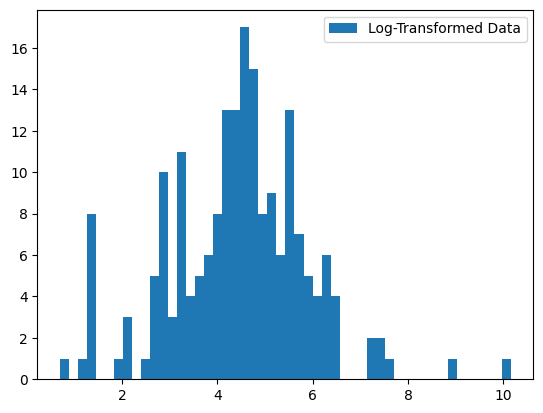

In [82]:
LRdata['log_pop'] = np.log(LRdata['Country People/Sq Km'])
LRdata['log_slope'] = np.log(LRdata['Slope between 2020 and 2022'])

# Plot the original data and the log-transformed data
import matplotlib.pyplot as plt
#plt.hist(data, bins=50, label='Original Data')
plt.hist(log_pop, bins=50, label='Log-Transformed Data')
plt.legend()
plt.show()

# Stat Anaz

### Region Statistics

##### Correlation

In [63]:
dropcords.corr(numeric_only = True)

,2020,2021,2022,2023,Slope between 2020 and 2022,Region Avg People/Sq Km
2020,1.000000,0.978109,0.743936,0.613456,0.721361,0.147506
2021,0.978109,1.000000,0.823572,0.687199,0.804981,0.233418
2022,0.743936,0.823572,1.000000,0.966313,0.999450,0.594589
2023,0.613456,0.687199,0.966313,1.000000,0.971014,0.611376
Slope between 2020 and 2022,0.721361,0.804981,0.999450,0.971014,1.000000,0.608896
Region Avg People/Sq Km,0.147506,0.233418,0.594589,0.611376,0.608896,1.000000


##### T-Test

In [64]:
df_R2022 = dropcords[2022]
Rpop_density = dropcords["Region Avg People/Sq Km"]
Rinfection_rate = dropcords["Slope between 2020 and 2022"]
t_stat, p_val = ttest_rel(Rpop_density, Rinfection_rate)


print("Paired T-Test Between Population Density and Infection Rate (2022):")
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_val}")

if p_val < 0.05:
    print("There is a significant difference.")
else:
    print("No significant difference found.")

Paired T-Test Between Population Density and Infection Rate (2022):
T-Statistic: -4.111917136887277
P-Value: 0.0005415195282484531
There is a significant difference.


### Country Statistics

##### Correlation

In [65]:
LRdata.corr(numeric_only = True)

,index,2020,2021,2022,2023,Country People/Sq Km,Slope between 2020 and 2022
index,1.000000,0.165222,0.169518,0.190892,0.177337,0.135309,0.191399
2020,0.165222,1.000000,0.990880,0.917312,0.863589,-0.022516,0.908203
2021,0.169518,0.990880,1.000000,0.938966,0.885000,-0.025592,0.931474
2022,0.190892,0.917312,0.938966,1.000000,0.986553,-0.026031,0.999751
2023,0.177337,0.863589,0.885000,0.986553,1.000000,-0.024008,0.988626
Country People/Sq Km,0.135309,-0.022516,-0.025592,-0.026031,-0.024008,1.000000,-0.026101
Slope between 2020 and 2022,0.191399,0.908203,0.931474,0.999751,0.988626,-0.026101,1.000000


##### T-Test

In [66]:
df_C2022 = LRdata[2022]
Cpop_density = LRdata["Country People/Sq Km"]
Cinfection_rate = LRdata["Slope between 2020 and 2022"]
t_stat, p_val = ttest_rel(Cpop_density, Cinfection_rate)


print("Paired T-Test Between Population Density and Infection Rate (2022):")
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_val}")

if p_val < 0.05:
    print("There is a significant difference.")
else:
    print("No significant difference found.")

Paired T-Test Between Population Density and Infection Rate (2022):
T-Statistic: -4.670433086707582
P-Value: 5.621445528010375e-06
There is a significant difference.




---



# Linear Regression - Countries

In [83]:
from sklearn.linear_model import LinearRegression

In [107]:
label = LRdata['Slope between 2020 and 2022']
features = LRdata[['Country People/Sq Km']]

In [108]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, label, test_size=0.2, random_state=42)

In [109]:
lr_model = LinearRegression()

In [110]:
lr_model.fit(X_train, y_train)

LinearRegression()

In [111]:
pred = lr_model.predict(X_test)


In [114]:
LRdata['Slope between 2020 and 2022'].describe()

,Slope between 2020 and 2022
count,1.940000e+02
mean,4.862177e+08
std,1.450020e+09
min,1.160000e+02
25%,7.539378e+06
50%,5.493690e+07
75%,2.681949e+08
max,1.505885e+10


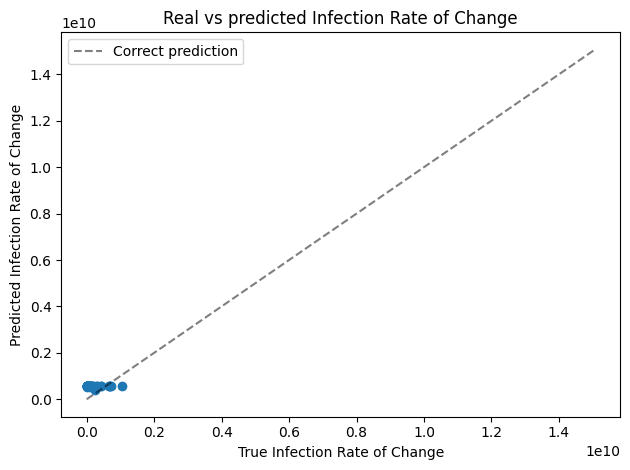

In [116]:
plt.scatter(y_test, pred)
plt.plot([1.160000e+02, 1.505885e+10], [1.160000e+02, 1.505885e+10], '--k', alpha = 0.5,label="Correct prediction")


plt.axis('tight')


plt.xlabel('True Infection Rate of Change')
plt.ylabel('Predicted Infection Rate of Change')
plt.title("Real vs predicted Infection Rate of Change")

plt.legend()
plt.tight_layout()


In [117]:
print('mean squared: ', mean_squared_error(y_test, pred))

print('mean absolute: ', mean_absolute_error(y_test, pred))

print('R2 score: ', r2_score(y_test, pred))

mean squared:  2.099525608735577e+17
mean absolute:  429644517.78819984
R2 score:  -2.250366903173131


* Mean Squared = Not Satisfactory
* Mean Absolute = Not Satisfactory
* R2 Score = Not Satisfactory

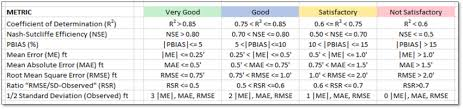



---



# Linear Regression - Regions

In [38]:
label2 = dropcords['Slope between 2020 and 2022']
features2 = dropcords[['Region Avg People/Sq Km']]

In [39]:
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(features, label, test_size=0.2, random_state=42)

In [40]:
lr_model2 = LinearRegression()

In [41]:
lr_model2.fit(X_train2, y_train2)

LinearRegression()

In [42]:
pred2 = lr_model2.predict(X_test2)

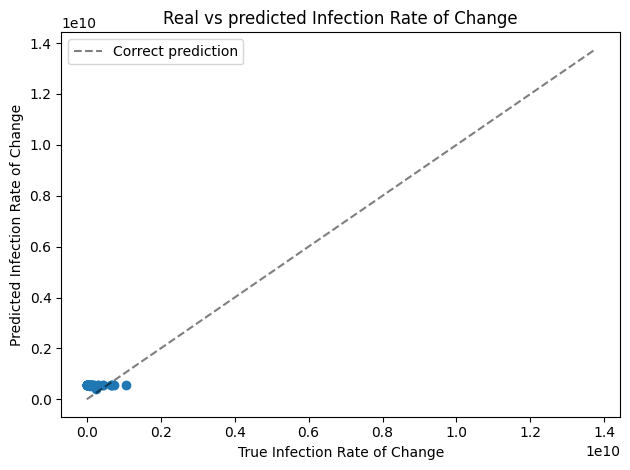

In [43]:
plt.scatter(y_test2, pred2)
plt.plot([2.833238e+06, 1.373440e+10], [2.833238e+06, 1.373440e+10], '--k', alpha = 0.5,label="Correct prediction")



plt.xlabel('True Infection Rate of Change')
plt.ylabel('Predicted Infection Rate of Change')
plt.title("Real vs predicted Infection Rate of Change")

plt.legend()
plt.tight_layout()

In [44]:
print('mean squared: ', mean_squared_error(y_test2, pred2))

print('mean absolute: ', mean_absolute_error(y_test2, pred2))

print('R2 score: ', r2_score(y_test2, pred2))

mean squared:  2.099525608735577e+17
mean absolute:  429644517.78819984
R2 score:  -2.250366903173131




---



# Final Visualizations

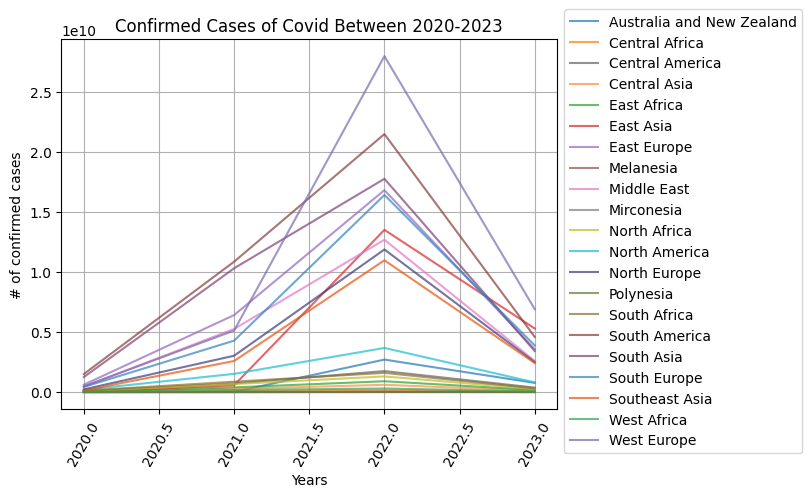

In [45]:
years = [2020, 2021, 2022, 2023]


AuNZ_values = [cleaned.iloc[0, 3], cleaned.iloc[0, 4], cleaned.iloc[0, 5], cleaned.iloc[0, 6]]

CenAf_values = [cleaned.iloc[1, 3], cleaned.iloc[1, 4], cleaned.iloc[1, 5], cleaned.iloc[1, 6]]

CenAm_values = [cleaned.iloc[2, 3], cleaned.iloc[2, 4], cleaned.iloc[2, 5], cleaned.iloc[2, 6]]

CenAs_values = [cleaned.iloc[3, 3], cleaned.iloc[3, 4], cleaned.iloc[3, 5], cleaned.iloc[3, 6]]

EaAf_values = [cleaned.iloc[4, 3], cleaned.iloc[4, 4], cleaned.iloc[4, 5], cleaned.iloc[4, 6]]

EaAs_values = [cleaned.iloc[5, 3], cleaned.iloc[5, 4], cleaned.iloc[5, 5], cleaned.iloc[5, 6]]

EaEu_values = [cleaned.iloc[6, 3], cleaned.iloc[6, 4], cleaned.iloc[6, 5], cleaned.iloc[6, 6]]

Mel_values = [cleaned.iloc[7, 3], cleaned.iloc[7, 4], cleaned.iloc[7, 5], cleaned.iloc[7, 6]]

MiEa_values = [cleaned.iloc[8, 3], cleaned.iloc[8, 4], cleaned.iloc[8, 5], cleaned.iloc[8, 6]]

Mirco_values = [cleaned.iloc[9, 3], cleaned.iloc[9, 4], cleaned.iloc[9, 5], cleaned.iloc[9, 6]]

NoAf_values = [cleaned.iloc[10, 3], cleaned.iloc[10, 4], cleaned.iloc[10, 5], cleaned.iloc[10, 6]]

NoAm_values = [cleaned.iloc[11, 3], cleaned.iloc[11, 4], cleaned.iloc[11, 5], cleaned.iloc[11, 6]]

NoEu_values = [cleaned.iloc[12, 3], cleaned.iloc[12, 4], cleaned.iloc[12, 5], cleaned.iloc[12, 6]]

Poly_values = [cleaned.iloc[13, 3], cleaned.iloc[13, 4], cleaned.iloc[13, 5], cleaned.iloc[13, 6]]

SoAf_values = [cleaned.iloc[14, 3], cleaned.iloc[14, 4], cleaned.iloc[14, 5], cleaned.iloc[14, 6]]

SoAm_values = [cleaned.iloc[15, 3], cleaned.iloc[15, 4], cleaned.iloc[15, 5], cleaned.iloc[15, 6]]

SoAs_values = [cleaned.iloc[16, 3], cleaned.iloc[16, 4], cleaned.iloc[16, 5], cleaned.iloc[16, 6]]

SoEu_values = [cleaned.iloc[17, 3], cleaned.iloc[17, 4], cleaned.iloc[17, 5], cleaned.iloc[17, 6]]

SEAs_values = [cleaned.iloc[18, 3], cleaned.iloc[18, 4], cleaned.iloc[18, 5], cleaned.iloc[18, 6]]

WeAf_values = [cleaned.iloc[19, 3], cleaned.iloc[19, 4], cleaned.iloc[19, 5], cleaned.iloc[19, 6]]

WeEu_values = [cleaned.iloc[20, 3], cleaned.iloc[20, 4], cleaned.iloc[20, 5], cleaned.iloc[20, 6]]



plt.plot(years, AuNZ_values, color='#1f77b4', alpha = 0.7, label='Australia and New Zealand') #1
plt.plot(years, CenAf_values, color='#ff7f0e',  alpha = 0.7, label='Central Africa') #2
plt.plot(years, CenAm_values, color='#636363', alpha = 0.7, label='Central America') #3
plt.plot(years, CenAs_values, color='#fd8d3c', alpha = 0.7, label='Central Asia') #4
plt.plot(years, EaAf_values, color='#2ca02c', alpha = 0.7, label='East Africa') #5
plt.plot(years, EaAs_values, color='#d62728', alpha = 0.7, label='East Asia') #6
plt.plot(years, EaEu_values, color='#9467bd', alpha = 0.7, label='East Europe') #7
plt.plot(years, Mel_values, color='#8c564b', alpha = 0.7, label='Melanesia') #8
plt.plot(years, MiEa_values, color='#e377c2', alpha = 0.7, label='Middle East') #9
plt.plot(years, Mirco_values, color='#7f7f7f', alpha = 0.7, label='Mirconesia') #10
plt.plot(years, NoAf_values, color='#bcbd22', alpha = 0.7, label='North Africa') #11
plt.plot(years, NoAm_values, color='#17becf', alpha = 0.7, label='North America') #12
plt.plot(years, NoEu_values, color='#393b79', alpha = 0.7, label='North Europe') #13
plt.plot(years, Poly_values, color='#637939', alpha = 0.7, label='Polynesia') #14
plt.plot(years, SoAf_values, color='#8c6d31', alpha = 0.7, label='South Africa') #15
plt.plot(years, SoAm_values, color='#843c39', alpha = 0.7, label='South America') #16
plt.plot(years, SoAs_values, color='#7b4173', alpha = 0.7, label='South Asia') #17
plt.plot(years, SoEu_values, color='#3182bd', alpha = 0.7, label='South Europe') #18
plt.plot(years, SEAs_values, color='#e6550d', alpha = 0.7, label='Southeast Asia') #19
plt.plot(years, WeAf_values,color='#31a354', alpha = 0.7, label='West Africa') #20
plt.plot(years, WeEu_values, color='#756bb1', alpha = 0.7, label='West Europe') #21


plt.ylabel('# of confirmed cases')
plt.xlabel('Years')
plt.title('Confirmed Cases of Covid Between 2020-2023')
plt.xticks(rotation = 60)
plt.legend()
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.1))
plt.savefig('CovidLine1.png')
plt.show()



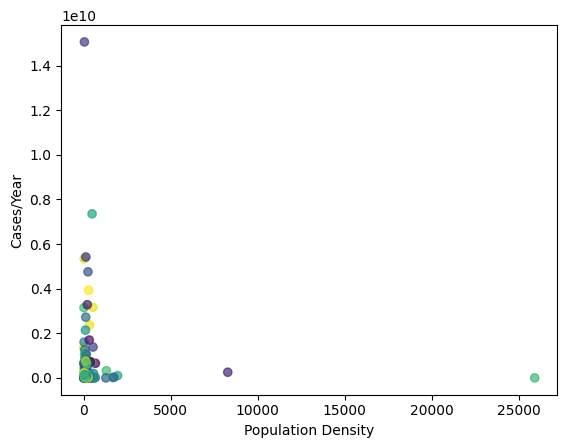

In [46]:
x = LRdata['Country People/Sq Km']
y = LRdata['Slope between 2020 and 2022']
colors = np.random.rand(194)
plt.scatter(x,y, alpha = 0.7, c=colors, cmap='viridis')
plt.xlabel('Population Density')
plt.ylabel('Cases/Year')
plt.show()

In [47]:
noextremes = LRdata.drop([182, 158, 193, 132])

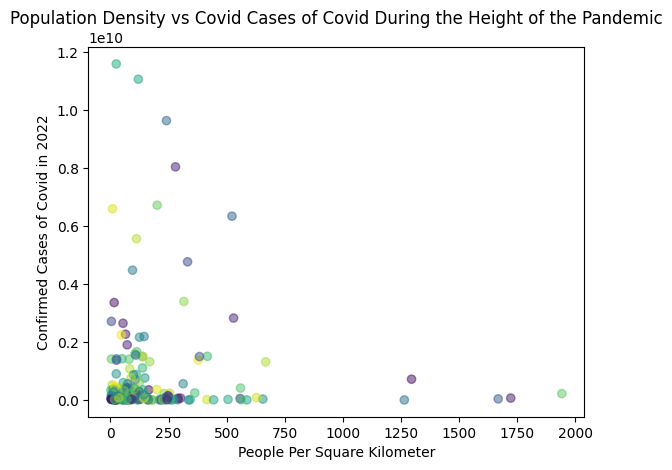

In [48]:
x = noextremes['Country People/Sq Km']
y = noextremes[2022]
colors = np.random.rand(190)
plt.scatter(x,y, alpha = 0.5, c=colors, cmap='viridis')
plt.title('Population Density vs Covid Cases of Covid During the Height of the Pandemic')
plt.xlabel('People Per Square Kilometer')
plt.ylabel('Confirmed Cases of Covid in 2022')
plt.show()

In [49]:
noextremes['Place'].unique()

array(['Australia and New Zealand', 'Central Africa', 'Central America',
       'Central Asia', 'East Africa', 'East Asia', 'East Europe',
       'Melanesia', 'Middle East', 'Mirconesia', 'North Africa',
       'North America', 'North Europe', 'Polynesia', 'South Africa',
       'South America', 'South Asia', 'South Europe', 'Southeast Asia',
       'West Africa', 'West Europe', nan], dtype=object)

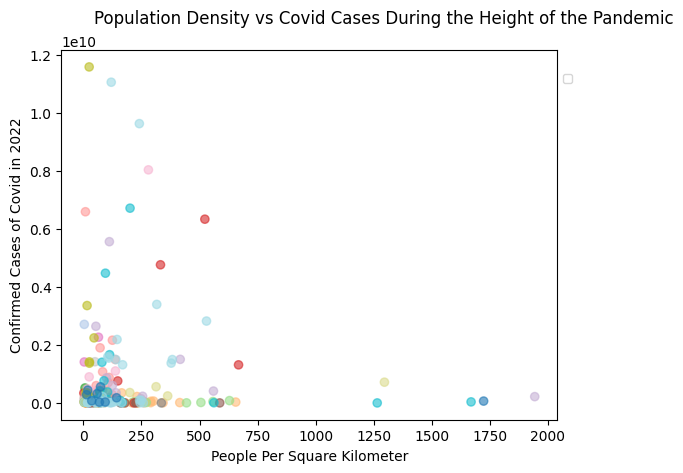

In [126]:

cat_column = noextremes['Place']
cat_series = pd.Series(cat_column)
cat_codes = cat_series.astype('category').cat.codes
categories = ['Australia and New Zealand', 'Central Africa', 'Central America',
       'Central Asia', 'East Africa', 'East Asia', 'East Europe',
       'Melanesia', 'Middle East', 'Mirconesia', 'North Africa',
       'North America', 'North Europe', 'Polynesia', 'South Africa',
       'South America', 'South Asia', 'South Europe', 'Southeast Asia',
       'West Africa', 'West Europe']

# Create a colormap (use tab10 for up to 10 distinct colors)
cmap = plt.cm.get_cmap('tab20', len(categories))

x = noextremes['Country People/Sq Km']
y = noextremes[2022]

plt.scatter(x, y, c=cat_codes, cmap=cmap, alpha=0.6)

plt.title('Population Density vs Covid Cases During the Height of the Pandemic', loc='center', x=0.65, y=1.05)
plt.xlabel('People Per Square Kilometer')
plt.ylabel('Confirmed Cases of Covid in 2022')
plt.legend( fontsize=8, loc='upper left', bbox_to_anchor=(1, 0.95))

plt.show()

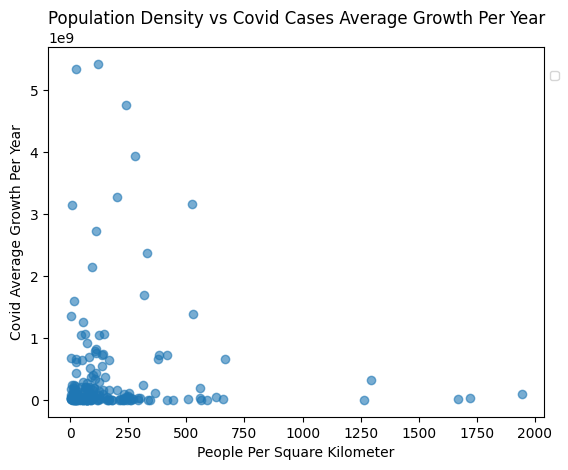

In [127]:
# @title
#cat_column = noextremes['Place']
#cat_series = pd.Series(cat_column)
#cat_codes = cat_series.astype('category').cat.codes
#categories = ['Australia and New Zealand', 'Central Africa', 'Central America',
      # 'Central Asia', 'East Africa', 'East Asia', 'East Europe',
       #'Melanesia', 'Middle East', 'Mirconesia', 'North Africa',
       #'North America', 'North Europe', 'Polynesia', 'South Africa',
       #'South America', 'South Asia', 'South Europe', 'Southeast Asia',
       #'West Africa', 'West Europe']

# Create a colormap (use tab10 for up to 10 distinct colors)
#cmap = plt.cm.get_cmap('tab20', len(categories))

x = noextremes['Country People/Sq Km']
y = noextremes['Slope between 2020 and 2022']

plt.scatter(x, y, alpha = 0.6)
            #c=cat_codes, cmap=cmap, alpha=0.6)
#plt.xlim(xmax=1250)
#plt.ylim(ymax=9000000000)

plt.title('Population Density vs Covid Cases Average Growth Per Year') #loc='center', x=0.65, y=1.05)
plt.xlabel('People Per Square Kilometer')
plt.ylabel('Covid Average Growth Per Year')
plt.legend( fontsize=8, loc='upper left', bbox_to_anchor=(1, 0.95))

plt.show()

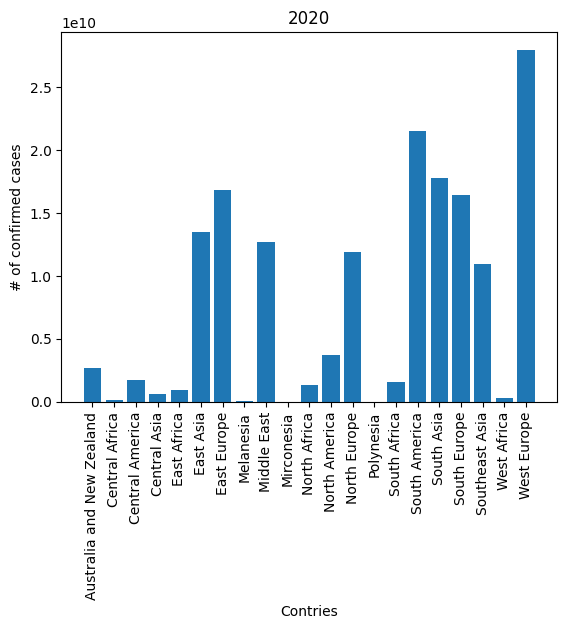

In [53]:
plt.bar(cleaned['Place'], cleaned[2022])


plt.xlabel('Contries')
plt.ylabel('# of confirmed cases')
plt.title('2020')
plt.xticks(rotation = 90)

plt.show()

TypeError: 'value' must be an instance of str or bytes, not a float

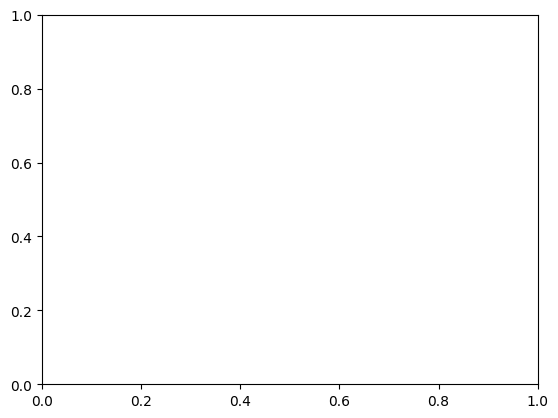

In [52]:
plt.bar(dropcords['Infection Speed'], dropcords['Region Avg People/Sq Km'])
plt.xlabel('Infection Speed')
plt.ylabel('Population Density')
plt.show()

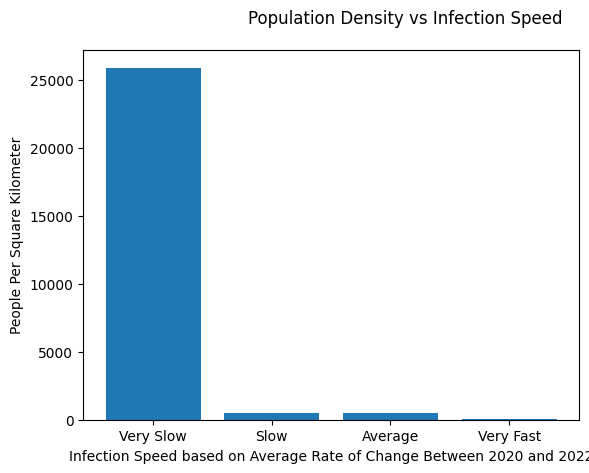

In [54]:
order = ['Very Slow', 'Slow', 'Average', 'Fast', 'Very Fast']

LRdata['Infection Speed'] = pd.Categorical(LRdata['Infection Speed'], categories=order, ordered=True)

LR_IS_sort = LRdata.sort_values('Infection Speed')

plt.bar(LR_IS_sort['Infection Speed'], LR_IS_sort['Country People/Sq Km'])
plt.title('Population Density vs Infection Speed', loc='center', x=0.65, y=1.05)
plt.xlabel('Infection Speed based on Average Rate of Change Between 2020 and 2022')
plt.ylabel('People Per Square Kilometer')
plt.show()


In [55]:
LRdata['Country People/Sq Km'].describe()

,Country People/Sq Km
count,194.000000
mean,349.000000
std,1953.899775
min,2.000000
25%,36.250000
50%,91.500000
75%,213.750000
max,25917.000000


In [56]:
LRdata['Slope between 2020 and 2022'].describe()

,Slope between 2020 and 2022
count,1.940000e+02
mean,4.862177e+08
std,1.450020e+09
min,1.160000e+02
25%,7.539378e+06
50%,5.493690e+07
75%,2.681949e+08
max,1.505885e+10


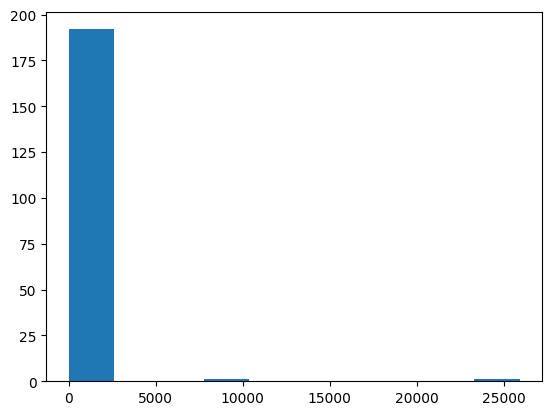

In [57]:
x = LRdata['Country People/Sq Km']

plt.hist(x)
plt.show()

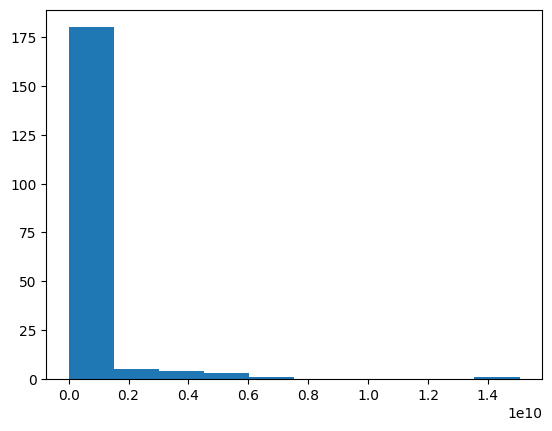

In [58]:
x = LRdata['Slope between 2020 and 2022']

plt.hist(x)
plt.show()

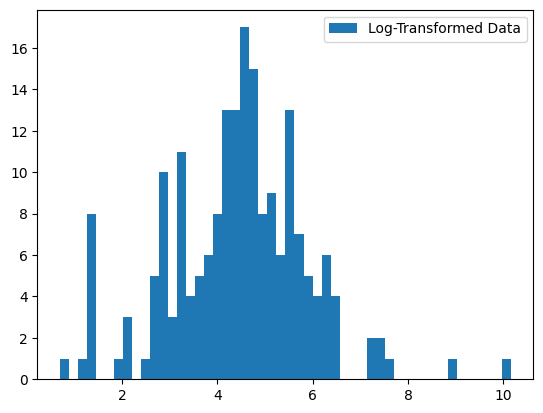



---

